## Monte-Carlo Simulation



In [2]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt

## 1.1
We implement a function create_data that takes the number of feature / instance pairs that we would like to sample as an argument. Using the inverse function of the cumulative probability distribution of p(X|Y=0), p(X|Y=1), respectively, we draw feautures that follow the given probability densities. In a first step, we draw the instances from the set {0,1} and then, depending on the value use the corresponding cum. PDF.
Note that the if / else statement is added for exercise 1.3 where we which to sample explicitly an instance of each class

In [3]:
def create_data(N):
    feature = np.empty(shape=N)
    unif_cum_prob = np.random.uniform(0.0,1.0,size=N) # generate N observations of cumulative probability
    if(N!=2):
        instance = np.random.randint(2,size=N) # generate N random unsigned ints between 0 and 2-1
    else:
        instance = np.array([1,0]) # to implement nearest neighbour algorithm where one instance of both classes is needed
    ind_y_one = np.where(instance == 1)
    ind_y_zero = np.where(instance == 0)
    feature[ind_y_one] = np.sqrt(unif_cum_prob[ind_y_one])
    feature[ind_y_zero] = -np.sqrt(1-unif_cum_prob[ind_y_zero])+1
    return feature, instance

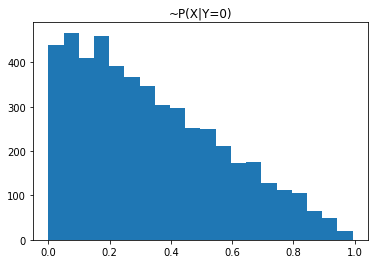

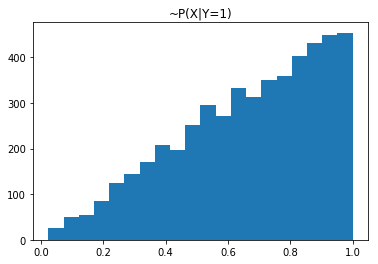

In [4]:
%matplotlib inline
N = 10**4
x,y = create_data(N) # generate test set
plt.hist(x[np.where(y==0)],bins=20);
plt.title('~P(X|Y=0)')
plt.show()
plt.hist(x[np.where(y==1)],bins=20);
plt.title('~P(X|Y=1)')
plt.show()

Above histograms show that the sampling function is doing a good job. Deviation from the theoretical PDF will be a result of the binning and the relatively small number of drawn samples

## 1.2

In [5]:
def rule_A(feature,t):
    return [(feature>t)]

def rule_B(feature,t):
    return [(feature<t)]

def p_error(rule,t,N):
    x,y = create_data(N)
    
    error = [1 - np.sum([y==rule(x,i)])/N for i in t]
    return error

In [42]:

t = np.array([0.2,0.5,0.6])
M = [10,100,1000,10000]
plot_std_A_B = np.zeros((4,2))
for i, N in enumerate(M):
    print("_____M = %d_____" % N)
    theo_error_ruleA = 0.25 + (t-0.5)**2
    theo_error_ruleB = 0.75 - (t-0.5)**2
    p_error_A = np.mean([p_error(rule_A,t,N) for i in np.arange(0,10)],axis=0)
    p_error_A_std = np.std([p_error(rule_A,t,N) for i in np.arange(0,10)],axis=0)
    p_error_B = np.mean([p_error(rule_B,t,N) for i in np.arange(0,10)],axis=0)
    p_error_B_std = np.std([p_error(rule_B,t,N) for i in np.arange(0,10)],axis=0)
    plot_std_A_B[i,:] = [p_error_A_std[1],p_error_B_std[1]]
    for i in np.arange(0,3):
        print("Rule A [t = %.3f] [error_exp] [error_exp_std] [error_theo]: %.3f %.5f %.3f" % (t[i], p_error_A[i], p_error_A_std[i],theo_error_ruleA[i]))
        print("Rule B [t = %.3f] [error_exp] [error_exp_std] [error_theo]: %.3f %.5f %.3f" % (t[i], p_error_B[i], p_error_B_std[i],theo_error_ruleB[i]))

_____M = 10_____
Rule A [t = 0.200] [error_exp] [error_exp_std] [error_theo]: 0.270 0.15620 0.340
Rule B [t = 0.200] [error_exp] [error_exp_std] [error_theo]: 0.690 0.20224 0.660
Rule A [t = 0.500] [error_exp] [error_exp_std] [error_theo]: 0.210 0.12042 0.250
Rule B [t = 0.500] [error_exp] [error_exp_std] [error_theo]: 0.840 0.14866 0.750
Rule A [t = 0.600] [error_exp] [error_exp_std] [error_theo]: 0.260 0.10770 0.260
Rule B [t = 0.600] [error_exp] [error_exp_std] [error_theo]: 0.790 0.12000 0.740
_____M = 100_____
Rule A [t = 0.200] [error_exp] [error_exp_std] [error_theo]: 0.359 0.04148 0.340
Rule B [t = 0.200] [error_exp] [error_exp_std] [error_theo]: 0.688 0.04859 0.660
Rule A [t = 0.500] [error_exp] [error_exp_std] [error_theo]: 0.260 0.04080 0.250
Rule B [t = 0.500] [error_exp] [error_exp_std] [error_theo]: 0.746 0.02468 0.750
Rule A [t = 0.600] [error_exp] [error_exp_std] [error_theo]: 0.258 0.04482 0.260
Rule B [t = 0.600] [error_exp] [error_exp_std] [error_theo]: 0.745 0.02872

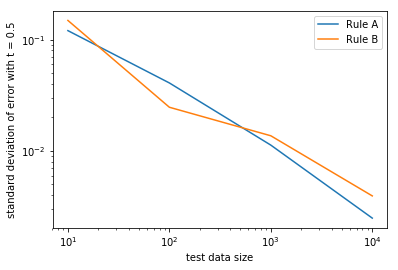

In [45]:
line1, = plt.plot(M,plot_std_A_B[:,0],label='Rule A')
line2, = plt.plot(M,plot_std_A_B[:,1],label='Rule B')
plt.legend(loc='best')
plt.xlabel('test data size')
plt.ylabel('standard deviation of error with t = 0.5')
plt.yscale('log')
plt.xscale('log')

We see that the experimentally estimated error is in very good agreement to the theoretical error. A log log plot of the std deviation of the error versus the test size reveals that the functional dependency follows a power law

## 1.3

In [47]:
def NN_class_1D(training_set,test_feature):
    """ Nearest neighbour classifier
    input is a (2,2) shaped array for the training data and a (N,) shaped array for the test_feature
    the absolute distance between training and test features is stored in a vector fashion (2,test_size) matrix
    and the idex of the training data class is stored in ind_instances. 
    The function returns then the corresponding classes
    """
    ind_instances = np.argmin(np.abs(training_set[0].reshape(2,1) - test_feature),axis=0) #returns sequence of indixes of the set {0,1} that are corresponding to the classes stored in training_instance
    return (training_set[1])[ind_instances]

In [50]:
n_total = 100 # number of cycles where training and test set are generated and error rate estimated
test_size = 10**5 # size of test data
error_array = np.empty(shape=n_total) # stores the estimated error of each cycle
for i in np.arange(0,n_total):
    test_data_x, test_data_y = create_data(test_size)
    training_data = create_data(2)
    estimated_instances = NN_class_1D(training_data,test_data_x)
    error_array[i] = 1 - np.sum(estimated_instances == test_data_y)/test_size
av_error = np.mean(error_array)
av_error_std = np.std(error_array)
print('Average error:',av_error, '+-',av_error_std)

Average error: 0.3376089 +- 0.158137323456


The estimated error is in good agreement with the theoretical value of 35%. Notice the high standard deviation.